In [25]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from dictionary import AutoEncoder

import matplotlib.pyplot as plt


In [4]:
s


['The capital of Russia is Moscow.', 'The capital of China is Beijing.', 'The capital of Greece is Athens.', 'The capital of Germany is Berlin.', 'The capital of France is Paris.', 'The capital of the United Kingdom is London.', 'The capital of Japan is Tokyo.', 'The capital of Egypt is Cairo.', 'The capital of Italy is Rome.', 'The capital of Spain is Madrid.', 'The capital of Portugal is Lisbon.', 'The capital of Canada is Ottawa.', 'The capital of Australia is Canberra.', 'The capital of Brazil is Brasília.', 'The capital of India is New Delhi.', 'The capital of the United States is Washington, D.C.', 'The capital of Argentina is Buenos Aires.', 'The capital of Mexico is Mexico City.', 'The capital of South Korea is Seoul.', 'The capital of Indonesia is Jakarta.', 'The capital of Thailand is Bangkok.', 'The capital of Norway is Oslo.', 'The capital of Sweden is Stockholm.', 'The capital of Finland is Helsinki.', 'The capital of Poland is Warsaw.', 'The capital of Austria is Vienna.'

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Processing: 'The capital of Russia is Moscow.'

Processing: 'The capital of China is Beijing.'

Processing: 'The capital of Greece is Athens.'

Processing: 'The capital of Germany is Berlin.'

Processing: 'The capital of France is Paris.'

Processing: 'The capital of the United Kingdom is London.'

Processing: 'The capital of Japan is Tokyo.'

Processing: 'The capital of Egypt is Cairo.'

Processing: 'The capital of Italy is Rome.'

Processing: 'The capital of Spain is Madrid.'

Processing: 'The capital of Portugal is Lisbon.'

Processing: 'The capital of Canada is Ottawa.'

Processing: 'The capital of Australia is Canberra.'

Processing: 'The capital of Brazil is Brasília.'

Processing: 'The capital of India is New Delhi.'

Processing: 'The capital of the United States is Washington, D.C.'

Processing: 'The capital of Argentina is Buenos Aires.'

Processing: 'The capital of Mexico is Mexico City.'

Processing: 'The capital of South Korea is Seoul.'

Processing: 'The capital of Indone

(array([ 2.,  0.,  0.,  1.,  3.,  3.,  1.,  4.,  1., 11.]),
 array([ 7.79105377,  8.32777786,  8.86450195,  9.40122604,  9.93795109,
        10.47467518, 11.01139927, 11.54812336, 12.0848484 , 12.62157249,
        13.15829659]),
 <BarContainer object of 10 artists>)

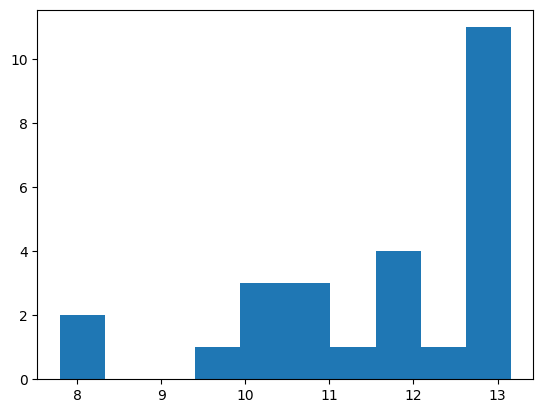

In [30]:
# Load the Pythia model and tokenizer
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer.pad_token = tokenizer.eos_token

ae = AutoEncoder.from_pretrained(
    "dictionaries/pythia-70m-deduped/mlp_out_layer3/10_32768/ae.pt", 
    map_location=torch.device('cpu')
)

In [31]:
# Testing tokenizer 
sentence = "The capital of Russia is Moscow. Moscow is in Russia."
tokenized_sentence = tokenizer(sentence)['input_ids']
decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

print("Tokenized output:", decoded_tokens)

Tokenized output: ['The', 'Ġcapital', 'Ġof', 'ĠRussia', 'Ġis', 'ĠMoscow', '.', 'ĠMoscow', 'Ġis', 'Ġin', 'ĠRussia', '.']


In [32]:
activation_list = []

def hook_fn(module, input, output):
    """Hook function to capture activations from the 4th MLP layer."""
    activation_list.append(output)

# Hook 4th MLP layer (index 3)
layer_to_hook = model.gpt_neox.layers[3].mlp
hook = layer_to_hook.register_forward_hook(hook_fn)


In [37]:
feature_vals = {}
    
for sentence in sentences:
    print(f"\nProcessing: '{sentence}'")
    input_ids_batch = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    model(**input_ids_batch)  # Forward pass to capture activations
    tokenized_sentence = tokenizer(sentence)['input_ids']
    decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)
    feature_vals[sentence] = {}

    if activation_list:
        activations = activation_list[-1].squeeze(0)  # Shape: (seq_len, hidden_dim)
        sparse_repr = ae.encode(activations).detach().cpu().numpy()
        for i in range(np.shape(sparse_repr)[0]):
            feature_vals[sentence][decoded_tokens[i]] = {}
            token_features = sparse_repr[i,:]
            sorted_feature_ind = np.argsort(token_features)[:][::-1]
            for ind in sorted_feature_ind:
                if token_features[ind] != 0.0:
                    feature_vals[sentence][decoded_tokens[i]][ind] = token_features[ind]
    activation_list.clear()





Processing: 'The capital of Russia is Moscow.'

Processing: 'The capital of China is Beijing.'

Processing: 'The capital of Greece is Athens.'

Processing: 'The capital of Germany is Berlin.'

Processing: 'The capital of France is Paris.'

Processing: 'The capital of the United Kingdom is London.'

Processing: 'The capital of Japan is Tokyo.'

Processing: 'The capital of Egypt is Cairo.'

Processing: 'The capital of Italy is Rome.'

Processing: 'The capital of Spain is Madrid.'

Processing: 'The capital of Portugal is Lisbon.'

Processing: 'The capital of Canada is Ottawa.'

Processing: 'The capital of Australia is Canberra.'

Processing: 'The capital of Brazil is Brasília.'

Processing: 'The capital of India is New Delhi.'

Processing: 'The capital of the United States is Washington, D.C.'

Processing: 'The capital of Argentina is Buenos Aires.'

Processing: 'The capital of Mexico is Mexico City.'

Processing: 'The capital of South Korea is Seoul.'

Processing: 'The capital of Indone

In [45]:
feature_vals[]

{'The capital of Russia is Moscow.': {'The': {np.int64(20383): np.float32(13.694209),
   np.int64(18192): np.float32(3.4926918),
   np.int64(21462): np.float32(2.7808285),
   np.int64(7082): np.float32(2.6421824),
   np.int64(29597): np.float32(1.4095589),
   np.int64(26654): np.float32(0.47874486),
   np.int64(9312): np.float32(0.1242184),
   np.int64(3959): np.float32(0.056859665),
   np.int64(10395): np.float32(0.0018113822),
   np.int64(19599): np.float32(0.0008985235)},
  'Ġcapital': {np.int64(22504): np.float32(2.9278865),
   np.int64(678): np.float32(0.30167985),
   np.int64(10887): np.float32(0.27435693),
   np.int64(6023): np.float32(0.24045113),
   np.int64(19964): np.float32(0.23183808),
   np.int64(20977): np.float32(0.22676677),
   np.int64(455): np.float32(0.20946634),
   np.int64(22857): np.float32(0.18347748),
   np.int64(15943): np.float32(0.17380702),
   np.int64(29223): np.float32(0.17172797),
   np.int64(24940): np.float32(0.1622703),
   np.int64(15763): np.float32(

In [46]:
feature = 18192

for sentence in feature_vals:
    for token in feature_vals[sentence]:
            if feature in feature_vals[sentence][token].keys():
                  print(sentence, token, feature_vals[sentence][token][feature])

The capital of Russia is Moscow. The 3.4926918
The capital of Russia is Moscow. . 6.7078824
The capital of China is Beijing. The 3.4926918
The capital of China is Beijing. . 6.7099133
The capital of Greece is Athens. The 3.4926918
The capital of Greece is Athens. . 6.678201
The capital of Germany is Berlin. The 3.4926918
The capital of Germany is Berlin. . 6.7060876
The capital of France is Paris. The 3.4926918
The capital of France is Paris. . 6.6751614
The capital of the United Kingdom is London. The 3.4926918
The capital of the United Kingdom is London. . 6.8134108
The capital of Japan is Tokyo. The 3.4926918
The capital of Japan is Tokyo. . 6.7282944
The capital of Egypt is Cairo. The 3.4926918
The capital of Egypt is Cairo. . 6.7181234
The capital of Italy is Rome. The 3.4926918
The capital of Italy is Rome. . 6.7160087
The capital of Spain is Madrid. The 3.4926918
The capital of Spain is Madrid. . 6.6901236
The capital of Portugal is Lisbon. The 3.4926918
The capital of Portugal 

In [29]:
print(len(individual_activations))

26


In [22]:
# Load Dictionary Learning AutoEncoder




In [23]:
# Convert activations to sparse representations
sparse_representations = []
for activations in individual_activations:
    sparse_repr = ae.encode(activations).detach().cpu().numpy()  # (seq_len, dict_size)
    sparse_representations.append(sparse_repr)
print(f"Processed {len(sparse_representations)} sentences into token-aligned sparse representations.")

Processed 26 sentences into token-aligned sparse representations.


In [24]:
# Aggregate features: Find top activated features across all tokens in all sentences
feature_counts = {}
for sentence_features in sparse_representations:
    for token_features in sentence_features:
        sorted_feature_ind = np.argsort(token_features)[:][::-1]
        



        for idx in top_indices:
            feature_counts[idx] = feature_counts.get(idx, 0) + 1
            

In [92]:
# # Analyze which features activate for specific tokens
# top_n = 800  
# top_features = []

# for sentence_idx, per_token_features in enumerate(sparse_representations):
#     sentence_top_features = []
    
#     for token_idx, features in enumerate(per_token_features):
#         # Extract top N active features for this token
#         top_indices = np.argsort(features)[-top_n:][::-1]
#         sentence_top_features.append(set(top_indices))
    
#     top_features.append(sentence_top_features)  # Store per-token top feature indices

# # Example: Print feature activations for each token in the first sentence
# tokenized_sentence = tokenizer(sentences[0])['input_ids']
# decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

# print("\nFeature activations for the first sentence:")
# for token, feature_set in zip(decoded_tokens, top_features[0]):
#     print(f"Token: {token}, Top Features: {list(feature_set)[:10]}")  # Show top 5 features

#     # Example: Print feature activations for each token in the first sentence
# tokenized_sentence = tokenizer(sentences[1])['input_ids']
# decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

# print("\nFeature activations for the first sentence:")
# for token, feature_set in zip(decoded_tokens, top_features[0]):
#     print(f"Token: {token}, Top Features: {list(feature_set)[:10]}")  # Show top 5 features
    


In [93]:
# Select the most frequently occurring features
top_common_features = sorted(feature_counts, key=feature_counts.get, reverse=True)[:800]

# Create a synthetic sparse vector using these common features
synthetic_sparse_vector = np.zeros((32768,))  # Assume dictionary size is 32768
for idx in top_common_features:
    synthetic_sparse_vector[idx] = 1  # Set these features as active

In [94]:
# Decode sparse vector back into model space
synthetic_dense_vector = ae.decode(torch.tensor(synthetic_sparse_vector).float()).detach().cpu()
synthetic_dense_vector *= 10  # Experiment with scaling


In [95]:
# Add a new special token
tokenizer.add_special_tokens({'additional_special_tokens': ["<XYZ>"]})
model.resize_token_embeddings(len(tokenizer))  # Resize embeddings to include new token

masked_sentence = "The capital of <XYZ> is"
input_ids = tokenizer(masked_sentence, return_tensors="pt")["input_ids"]

# Convert token IDs to tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(f"Tokenized input: {decoded_tokens}")  # Debugging

# **Find the placeholder index**
try:
    placeholder_index = decoded_tokens.index("<XYZ>")
except ValueError:
    raise ValueError(f"Could not find placeholder token in: {decoded_tokens}")


Tokenized input: ['The', 'Ġcapital', 'Ġof', 'Ġ', '<XYZ>', 'Ġis']


In [82]:

# Convert input_ids to embeddings
model_inputs = model.get_input_embeddings()(input_ids)

# Inject synthetic feature vector at the placeholder position
model_inputs[:, placeholder_index, :] = synthetic_dense_vector

# Generate text from modified embeddings
with torch.no_grad():
    outputs = model(inputs_embeds=model_inputs)
    logits = outputs.logits[:, -1, :]  # Get last token logits
    predicted_token_id = torch.argmax(logits, dim=-1).item()

# Decode the predicted token
predicted_word = tokenizer.decode([predicted_token_id])

print(f"Predicted token: {predicted_word}")

Predicted token:  the
